<a href="https://colab.research.google.com/github/buisonanh/phishing_urls_detection/blob/main/phishing_urls_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# **Import Data**

In [2]:
# Import data
legit = pd.read_csv("datasets/URL/Benign_list_big_final.csv")
phishing = pd.read_csv("datasets/URL/phishing_dataset.csv")
phishing2 = pd.read_csv("datasets/phishing_urls.csv")
malware = pd.read_csv("datasets/URL/Malware_dataset.csv")
spam = pd.read_csv("datasets/URL/spam_dataset.csv")


In [3]:
legit.columns = ['url']

phishing.columns = ['url']
malware.columns = ['url']
spam.columns = ['url']

malicious = pd.concat([phishing, malware, spam])

# **Prepare Data**

In [4]:
# Check null values
print(f"Legit null values: {legit.isnull().sum()}")
print()
print(f"Malicious null values: {malicious.isnull().sum()}")

Legit null values: url    0
dtype: int64

Malicious null values: url    0
dtype: int64


In [5]:
# Drop duplicates
print(f"Legit's duplicates num: {legit.duplicated().sum()}")
print(f"Malicious duplicates num: {malicious.duplicated().sum()}")
legit = legit.drop_duplicates()
malicious = malicious.drop_duplicates()

print(legit.shape)
print(malicious.shape)

print(f"Legit's duplicates num: {legit.duplicated().sum()}")
print(f"Malicious duplicates num: {malicious.duplicated().sum()}")

Legit's duplicates num: 0
Malicious duplicates num: 8962
(35377, 1)
(24566, 1)
Legit's duplicates num: 0
Malicious duplicates num: 0


In [6]:
# add a 'label' column to the dataframes
legit["label"] = 0
malicious["label"] = 1

In [7]:
# combine the two dataframes
df = pd.concat([legit, malicious], ignore_index=True)

# shuffle the dataframe's rows randomly
df = df.sample(frac=1, random_state=42) # Set random_state to an integer for reproducibility

print(df.shape)

(59943, 2)


In [8]:
# print the counts for each category
counts = df["label"].value_counts()
print(counts)

label
0    35377
1    24566
Name: count, dtype: int64


In [9]:
print(df.isnull().sum())

url      0
label    0
dtype: int64


## Fixing Imbalance

In [10]:
"""
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of RandomUnderSampler
rus = RandomUnderSampler()

X = df['url']
y = df['label']

# Oversample the data
X_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)

# Create a new balanced dataframe
df = pd.DataFrame({'url': X_resampled.flatten(), 'label': y_resampled})

print(df['label'].value_counts())
"""

"\nfrom imblearn.under_sampling import RandomUnderSampler\n\n# Create an instance of RandomUnderSampler\nrus = RandomUnderSampler()\n\nX = df['url']\ny = df['label']\n\n# Oversample the data\nX_resampled, y_resampled = rus.fit_resample(X.values.reshape(-1, 1), y)\n\n# Create a new balanced dataframe\ndf = pd.DataFrame({'url': X_resampled.flatten(), 'label': y_resampled})\n\nprint(df['label'].value_counts())\n"

# **Extracting Features**

In [11]:
# importing required packages for this section
from urllib.parse import urlparse
import ipaddress
import re

# 1.Domain of the URL (Domain) 
def getDomain(url):  
    domain = urlparse(url).netloc
    if re.match(r"^www.",domain):
            domain = domain.replace("www.","")
    return domain

# 2.Checks for IP address in URL (Have_IP)
def havingIP(url):
    try:
        ipaddress.ip_address(url)
        ip = 1
    except:
        ip = 0
    return ip

# 3.Checks the presence of @ in URL (Have_At)
def haveAtSign(url):
    if "@" in url:
        at = 1
    else:
        at = 0    
    return at

# 4.Finding the length of URL and categorizing (URL_Length)
def getLength(url):
    if len(url) < 54:
        return 1
    else:
        return 0

# 5.Gives number of '/' in URL (URL_Depth)
def getDepth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth = depth+1
    return depth

# 6.Checking for redirection '//' in the url (Redirection)
def redirection(url):
    pos = url.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

# 7.Existence of “HTTPS” Token in the Domain Part of the URL (https_Domain)
def httpDomain(url):
    domain = urlparse(url).netloc
    if 'https' in domain:
        return 1
    else:
        return 0

In [12]:
def featureExtraction(url,label):
    
    features = []
    features.append(url)
    #Address bar based features (10)
    features.append(getDomain(url))
    features.append(havingIP(url))
    features.append(haveAtSign(url))
    features.append(getLength(url))
    features.append(getDepth(url))
    features.append(redirection(url))
    features.append(httpDomain(url))
    features.append(label)

    return features

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
features = []

for i in range(len(df)):
    url = df['url'][i]
    label = df['label'][i]

    features.append(featureExtraction(url,label))

In [15]:
#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)
df[1:10000]

,url,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,label
1,https://medium.com/human-parts/i-was-diagnosed...,medium.com,0,0,0,2,0,0,0
2,http://adservers.co.uk/scr/clk.aspx?ec=o03Ct0J...,adservers.co.uk,0,0,0,2,0,0,1
3,http://venturebeat.com/2015/01/29/facebook-inv...,venturebeat.com,0,0,0,4,0,0,0
4,http://www.hydro-jamet.big.net.pl/electron/qpy...,hydro-jamet.big.net.pl,0,0,0,2,0,0,1
5,http://ahds.ac.uk/ictguides/methods/method.jsp...,ahds.ac.uk,0,0,0,3,0,0,1
...,...,...,...,...,...,...,...,...,...
9995,http://extratorrent.cc/torrent/4190913/Black.O...,extratorrent.cc,0,0,0,3,0,0,0
9996,http://us.battle.net.ok.ttweb.asia/login/en/lo...,us.battle.net.ok.ttweb.asia,0,0,0,3,1,0,1
9997,http://www.thesmetimes.com/redirecct/Yahoo-PLA...,thesmetimes.com,0,0,0,4,0,0,1
9998,http://aboutscotland.co.uk/argylls/93norleans....,aboutscotland.co.uk,0,0,1,2,0,0,1


In [16]:
# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))

# **EDA**

<Axes: xlabel='https_Domain', ylabel='count'>

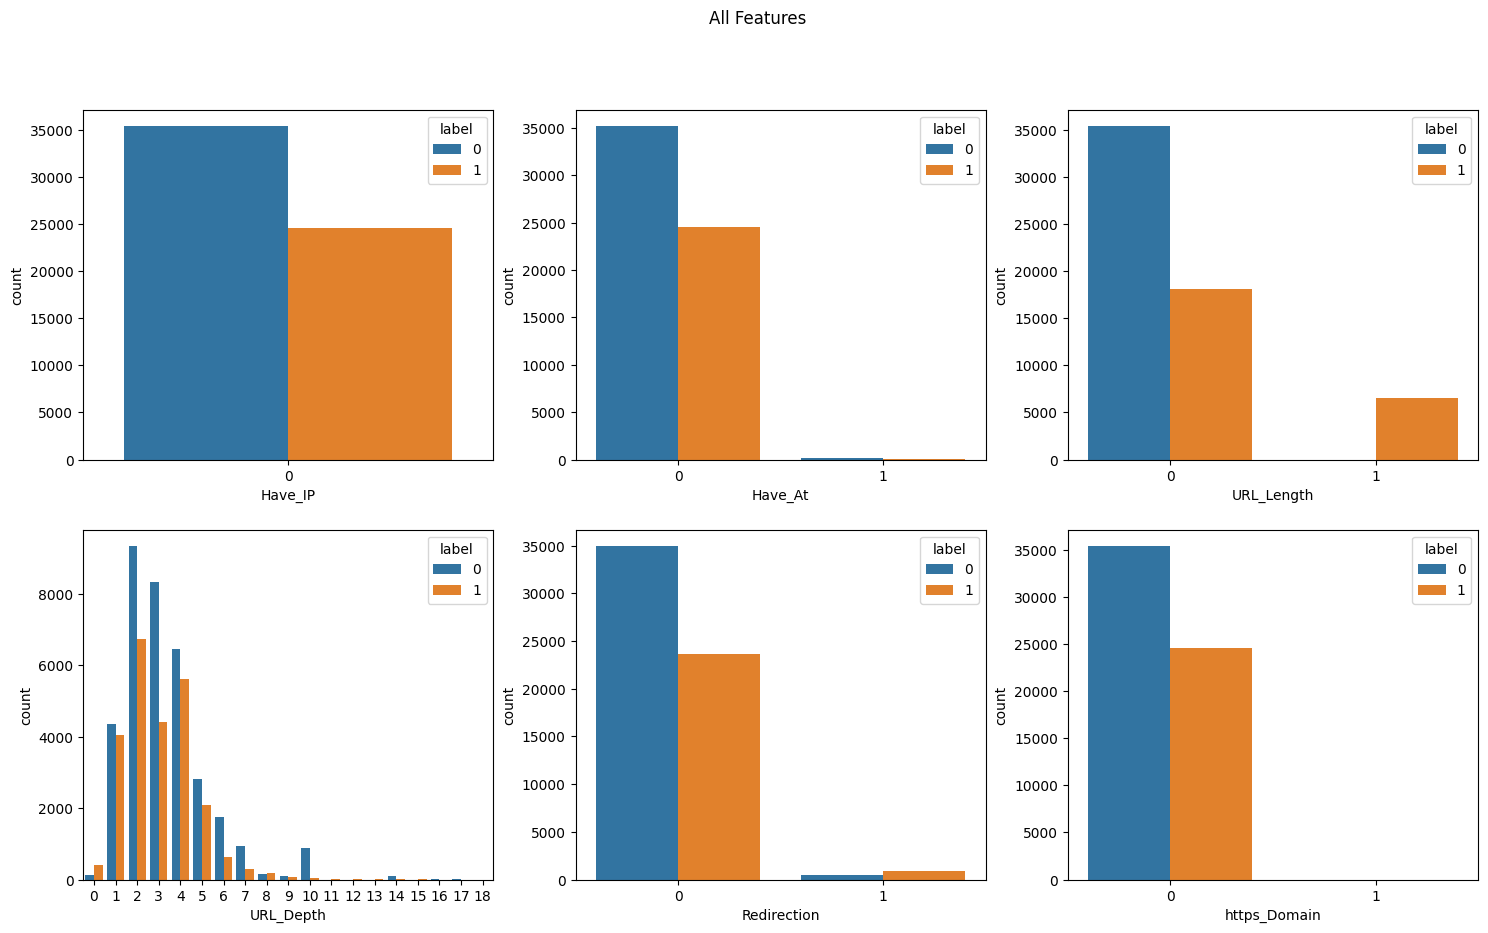

In [17]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('All Features')

iris = sns.load_dataset("iris")

sns.countplot(ax=axes[0, 0], data=df, x="Have_IP", hue="label")
sns.countplot(ax=axes[0, 1], data=df, x="Have_At", hue="label")
sns.countplot(ax=axes[0, 2], data=df, x="URL_Length", hue="label")
sns.countplot(ax=axes[1, 0], data=df, x="URL_Depth", hue="label")
sns.countplot(ax=axes[1, 1], data=df, x="Redirection", hue="label")
sns.countplot(ax=axes[1, 2], data=df, x="https_Domain", hue="label")

##### Features to be used: Domain, URL_Length, URL_Depth, Redirection 
##### Useless features: Have_IP, Have_At, https_Domain

# **Vectorizing and Encoding**

In [18]:
# Data selection
url_df = df['url']
domain_df = df['Domain']
depth_df = df['URL_Depth']
feature_df = df[['Redirection', 'URL_Length']]
label_df = df['label']

In [19]:
from sklearn import preprocessing

depth_arr = np.asarray(depth_df)

# Reshape depth_arr to a 2D array
depth_arr_2d = np.reshape(depth_arr, (-1, 1))

# Apply StandardScaler
scaler_depth = preprocessing.StandardScaler().fit(depth_arr_2d)

depth_scaled = scaler_depth.transform(depth_arr_2d)

depth_scaled[:5]

array([[ 0.97880968],
       [-0.63483858],
       [-0.63483858],
       [ 0.44092693],
       [-0.63483858]])

In [20]:
# Transform data
from sklearn.feature_extraction.text import CountVectorizer

import scipy.sparse as sp

# Vectorize URLs
vectorizer_url = CountVectorizer()
url_vec = vectorizer_url.fit_transform(url_df)

# Vectorize Domains
vectorizer_domain = CountVectorizer()
domain_vec = vectorizer_domain.fit_transform(domain_df)

features_arr = np.asarray(feature_df)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr), depth_scaled), format='csr')

# Encode label column
label_arr = np.asarray(label_df)


In [21]:
label_arr

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [22]:
"""
from imblearn.over_sampling import RandomOverSampler

# create a RandomOverSampler object and fit it to the data
oversampler = RandomOverSampler(random_state=42)
combined_features_arr_balanced, label_arr_balanced = oversampler.fit_resample(combined_features_arr, label_arr)

# check the new class distribution
pd.Series(label_arr_balanced).value_counts()
"""

'\nfrom imblearn.over_sampling import RandomOverSampler\n\n# create a RandomOverSampler object and fit it to the data\noversampler = RandomOverSampler(random_state=42)\ncombined_features_arr_balanced, label_arr_balanced = oversampler.fit_resample(combined_features_arr, label_arr)\n\n# check the new class distribution\npd.Series(label_arr_balanced).value_counts()\n'

# **Logistic Regression**

In [23]:
# chia tap train, test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(combined_features_arr, label_arr, test_size=0.25, random_state=42)

print('Train: ', x_train.shape[0])
print('Test: ', x_test.shape[0])

Train:  44957
Test:  14986


In [24]:

# modeling lbfgs
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C= 0.01, class_weight= None, max_iter= 500, penalty= 'l2', random_state=42)
lr_lbfgs = logreg.fit(x_train,y_train)


In [25]:
"""
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'max_iter': [100, 500, 1000],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


# Output:
# Best parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}
# Best cross-validation score: 0.9966857228917331
"""

'\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\'C\': [0.001, 0.01, 0.1, 1, 10],\n              \'penalty\': [\'l1\', \'l2\'],\n              \'max_iter\': [100, 500, 1000],\n              \'class_weight\': [None, \'balanced\']}\n\ngrid_search = GridSearchCV(LogisticRegression(solver=\'lbfgs\'),\n                           param_grid,\n                           cv=5,\n                           scoring=\'accuracy\',\n                           n_jobs=-1)\n\ngrid_search.fit(x_train, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nprint(f"Best cross-validation score: {grid_search.best_score_}")\n\n\n# Output:\n# Best parameters: {\'C\': 10, \'class_weight\': \'balanced\', \'max_iter\': 100, \'penalty\': \'l2\'}\n# Best cross-validation score: 0.9966857228917331\n'

In [26]:
y_pred=logreg.predict(x_test)
print(y_pred)

[1 1 1 ... 0 0 1]


In [27]:
from sklearn.metrics import jaccard_score
print(f"Jaccard score: {jaccard_score(y_test, y_pred,pos_label=0)}")

Jaccard score: 0.9543185763888888


In [28]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")


Accuracy: 0.97
F1 score: 0.96


In [29]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[8795,   59],
       [ 362, 5770]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

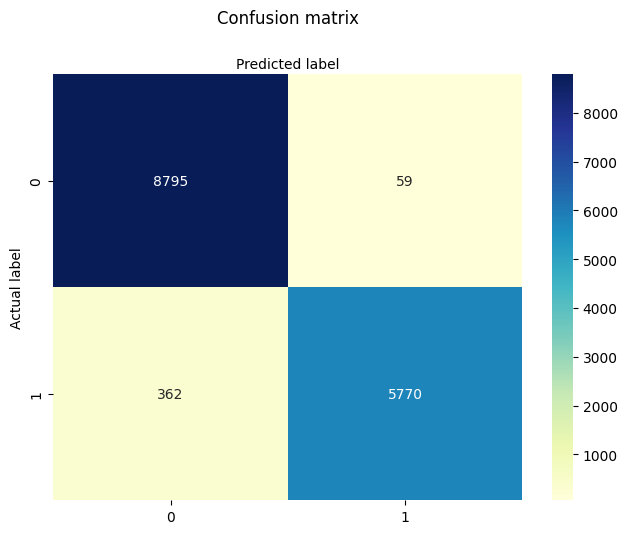

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# **(Test)**

In [31]:
test_df = pd.read_csv('datasets/publish_test.csv')
test_df.head(30)

,x,y,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1,NaN,NaN,NaN
1,http://ca.linkedin.com/directory/people/ca/pou...,0,NaN,NaN,NaN
2,http://www.ccent.com.au/index.php?option=com_m...,1,NaN,NaN,NaN
3,http://applerugs.co.uk/rugs/product_info.php?p...,1,NaN,NaN,NaN
4,http://mo-artworks.com/blog/diverse-videos/ein...,1,NaN,NaN,NaN
5,http://spoke.com/info/pF2WnMN/ZachTrimmer,0,NaN,NaN,NaN
6,http://www.ricardoitalo.com.br/portal/index.ph...,1,NaN,NaN,NaN
7,http://sexshop-bg.biz/products?page=shop.produ...,1,NaN,NaN,NaN
8,http://www.beriva.lt/index.html?di=akcijos&R=1...,1,NaN,NaN,NaN
9,http://ma.facevena.xyz/app/facebook.com/?lang=...,1,NaN,NaN,NaN


In [32]:
test = test_df[['x','y']]

test.isnull().sum()
test.dropna()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   x       100 non-null    object
 1   y       100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [33]:
indexValue = test[test['y'] == 'continue=to&amp'].index
test.drop(indexValue , inplace=True)

test.reset_index(drop=True, inplace=True)

test[:100]

C:\Users\Admin\AppData\Local\Temp\ipykernel_13972\599984414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(indexValue , inplace=True)


,x,y
0,http://newmatdesign.ro/wp-admin/wewe/YAHOO/ya....,1
1,http://ca.linkedin.com/directory/people/ca/pou...,0
2,http://www.ccent.com.au/index.php?option=com_m...,1
3,http://applerugs.co.uk/rugs/product_info.php?p...,1
4,http://mo-artworks.com/blog/diverse-videos/ein...,1
...,...,...
94,http://www.x-lonne.nl/fotoboek/image?format=ra...,1
95,http://www.redcitysoul.co.uk/index.php/compone...,1
96,http://www.babolna.eu/index.php?option=com_sob...,1
97,http://www.ninopizzaria.com.br/index.php?optio...,1


In [34]:
x_t = test['x']
y_t = test['y'].astype(int)

features = []

for i in range(0, 99):
    url = x_t[i]
    label = y_t[i]


    features.append(featureExtraction(url,label))


#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)


# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))


# Data selection
url_df = df['url']
domain_df = df['Domain']
depth_df = df['URL_Depth']
feature_df = df[['Redirection', 'URL_Length']]
label_df = df['label']

# Scale depth feature
depth_arr = np.asarray(depth_df)
# Reshape depth_arr to a 2D array
depth_arr_2d = np.reshape(depth_arr, (-1, 1))
# Apply StandardScaler
depth_scaled = scaler_depth.transform(depth_arr_2d)


import scipy.sparse as sp

# Vectorize URLs
url_vec = vectorizer_url.transform(url_df)


# Vectorize Domains
domain_vec = vectorizer_domain.transform(domain_df)

features_arr = np.asarray(feature_df)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr), depth_scaled), format='csr')
print(combined_features_arr)

# Encode label column
y_t = np.asarray(label_df)

  (0, 33630)	1.0
  (0, 44893)	1.0
  (0, 56991)	1.0
  (0, 65777)	1.0
  (0, 75452)	1.0
  (0, 83320)	1.0
  (0, 83376)	1.0
  (0, 90336)	1.0
  (0, 92108)	1.0
  (0, 92109)	0.4409269270053537
  (1, 41301)	2.0
  (1, 43062)	1.0
  (1, 45579)	1.0
  (1, 49634)	1.0
  (1, 63014)	1.0
  (1, 63595)	1.0
  (1, 65777)	1.0
  (1, 70449)	1.0
  (1, 86349)	1.0
  (1, 86655)	1.0
  (1, 92109)	0.4409269270053537
  (2, 36562)	1.0
  (2, 41879)	1.0
  (2, 43062)	2.0
  (2, 43091)	1.0
  :	:
  (97, 43062)	2.0
  (97, 43091)	1.0
  (97, 57846)	1.0
  (97, 58316)	1.0
  (97, 63587)	1.0
  (97, 67162)	1.0
  (97, 69707)	1.0
  (97, 82510)	1.0
  (97, 82692)	1.0
  (97, 86256)	1.0
  (97, 86655)	1.0
  (97, 92109)	-1.1727213361808924
  (98, 7090)	1.0
  (98, 22250)	1.0
  (98, 43062)	1.0
  (98, 49137)	1.0
  (98, 50093)	1.0
  (98, 54673)	1.0
  (98, 57846)	1.0
  (98, 58316)	1.0
  (98, 68332)	1.0
  (98, 80980)	1.0
  (98, 81858)	1.0
  (98, 86655)	1.0
  (98, 92109)	-1.1727213361808924


In [35]:
logreg.coef_.shape[1]

92110

In [36]:
y_t_pred = logreg.predict(combined_features_arr)
print(y_t_pred)

[1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1]


In [37]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_t, y_t_pred,pos_label=0))

0.3137254901960784


In [38]:
accuracy = accuracy_score(y_t, y_t_pred)
f1 = f1_score(y_t, y_t_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.65
F1 score: 0.73


Text(0.5, 427.9555555555555, 'Predicted label')

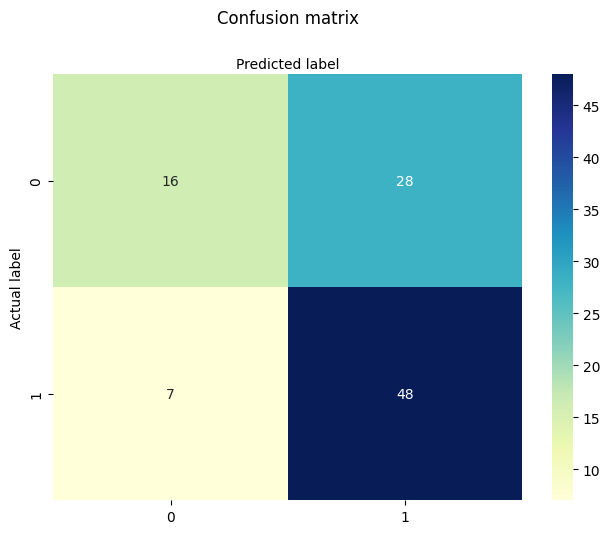

In [39]:
cnf_matrix = metrics.confusion_matrix(y_t, y_t_pred)
cnf_matrix

class_names=[] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# **Custom Test**

In [40]:
new_url = 'https://www.coursera.org/learn/machine-learning/lecture/1Z0TT/cost-function-formula'

features = []

for i in range(0, 99):
    url = new_url
    label = None

    features.append(featureExtraction(url,label))


#converting the list to dataframe
feature_names = ['url', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth','Redirection','https_Domain', 'label']

df = pd.DataFrame(features, columns= feature_names)


# delete symbols
import re
df["url"] = df["url"].apply(lambda x: re.sub('[/\.;?=https:\']', ' ', x))


# Data selection
url_df = df['url']
domain_df = df['Domain']
depth_df = df['URL_Depth']
feature_df = df[['URL_Length','Redirection']]
label_df = df['label']

depth_arr = np.asarray(depth_df)
depth_arr

import numpy as np

# Reshape depth_arr to a 2D array
depth_arr_2d = np.reshape(depth_arr, (-1, 1))

# Apply StandardScaler
depth_scaler = scaler.transform(depth_arr_2d)
depth_scaler[:5]


import scipy.sparse as sp

# Vectorize URLs
url_vec = vectorizer_url.transform(url_df)


# Vectorize Domains
domain_vec = vectorizer_domain.transform(domain_df)

features_arr = np.asarray(feature_df)



# Convert depth_arr_2d to a sparse matrix
depth_sparse = sp.csr_matrix(depth_arr_2d)

# Concatenate url_vec, domain_vec, and features_arr as sparse matrices
combined_features_arr = sp.hstack((url_vec, domain_vec, sp.csr_matrix(features_arr), depth_sparse), format='csr')

# Make prediction using trained model
prediction = logreg.predict(combined_features_arr)

if prediction[0] == 0:
    print('Legitimate')
elif prediction[0] == 1:
    print('Phishing')
else:
    print('Error')

NameError: name 'scaler' is not defined